In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from qutip import *
from qutip.control import *
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz

from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from dataclasses import dataclass
from typing import List, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

from scipy.constants import physical_constants, h

from qutip.operators import jmat, tensor, identity, Qobj

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_bloch_multivector

In [4]:
#defining constants in hamiltonian
h= 6.582119 * 1e-16 #eV * sec 
Bperpendicular = 10 #mT
Bparallel = 10 #mT
gammanv = 2*np.pi*28 * 1000000 #Hz/mT
omeganv = Bparallel * gammanv
omegamw = 1000000000 #Hz
Delta = omeganv - omegamw
#Delta
Omega = Bperpendicular * gammanv
Omega

#constants

f_fine_structure = 2.87e9
f_nuclear_quadrupole = -5.01e6
f_axial_magnetic_hyperfine = -2.14e6
f_transverse_magnetic_hyperfine = -2.7e6
g_factor_electron = 2.0028
gyromagnetic_constant_nuclear = 1.93297e7 / (2 * np.pi)
uB = physical_constants['Bohr magneton'][0]
uN = physical_constants['nuclear magneton'][0]    


#5/23/23 3:57 pm -- I think gammanv and the gyromagnetic constant nuclear are the same??? 

In [5]:
#HB is the Zeeman term of the Hamiltonian, here is also where I divide Delta and Omega by a factor of a billion
#and round up to give it these values

h=1
Delta = 8
Omega = 18
HB= h*Delta*sigmaz() + h*Omega*sigmax() + h*Omega*sigmay() 
HB


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 8. +0.j 18.-18.j]
 [18.+18.j -8. +0.j]]

In [7]:
nuclear_spin = 1
electron_spin = 1
identity3 = identity(3)

sigmaxE = jmat(electron_spin,'x')
sigmayE = jmat(electron_spin,'y')
sigmazE = jmat(electron_spin,'z')
sigmaxN = jmat(nuclear_spin,'x')
sigmayN = jmat(nuclear_spin,'y')
sigmazN = jmat(nuclear_spin,'z')
sigmazEsquared = sigmazE*sigmazE
sigmazNsquared = sigmazN*sigmazN

H_opsEx=tensor(sigmaxE, identity3)
H_opsEy=tensor(sigmayE, identity3)
H_opsEz=tensor(sigmazE, identity3)

H_opsNx=tensor(identity3, sigmaxN)
H_opsNy=tensor(identity3, sigmayN)
H_opsNz=tensor(identity3, sigmazN)

H_opsENx = tensor(sigmaxE, sigmaxN)
H_opsENy = tensor(sigmayE, sigmayN)           
H_opsENz = tensor(sigmazE, sigmazN)

H_opsEx.dims=[[9],[9]]
H_opsEy.dims=[[9],[9]]
H_opsEz.dims=[[9],[9]]

H_opsNx.dims=[[9],[9]]
H_opsNy.dims=[[9],[9]]
H_opsNz.dims=[[9],[9]]

H_opsENx.dims=[[9],[9]]
H_opsENy.dims=[[9],[9]]
H_opsENz.dims=[[9],[9]] 


In [8]:
SigmaZeemanx = Qobj([[0,1,0],[1,0,0],[0,0,0]])
SigmaZeemany = Qobj([[0,+1.j,0],[-1.j,0,0],[0,0,0]])
H_opsSigZeex = tensor(SigmaZeemanx,identity(3))
H_opsSigZeey = tensor(SigmaZeemany,identity(3))

H_opsSigZeex.dims = [[9],[9]]
H_opsSigZeey.dims = [[9],[9]]
#making H_ops list           
H_ops = [Omega*H_opsSigZeex, Omega*H_opsSigZeey]

#Labels for the graph
H_labels = [r'$u_{x}$',
            r'$u_{y}$',]
#,H_opsEz, H_opsNx, H_opsNy, H_opsNz]   #, H_opsENx, H_opsENy, H_opsENz]            
               
               
#making labels for pulse sequence graphs
#H_labels = [r'$uE_{x}$',
            #r'$uE_{y}$']

           
            #,r'$uE_{z}$',
            #r'$uN_{x}$',
            #r'$uN_{y}$',
            #r'$uN_{z}$',
            #r'$uEN_{x}$',
            #r'$uEN_{y}$',
            #r'$uEN_{z}$']


In [26]:
qubit1state=basis(3, 0)
qubit2state=basis(3, 0)
startingstate=tensor(qubit1state,qubit1state) #initial state
#endingstate= tensor(basis(3,0),basis(3,2))
startingstate.dims=[[9],[1]]
#endingstate.dims=[[9],[1]]
#print (startingstate)



#manually writing rx and U 

phi = np.pi
rx = Qobj([[np.cos(phi/2) ,-1.j * np.sin(phi/2),0],
[-1.j *np.sin(phi/2) ,np.cos(phi/2),0],
[0,0,0]])
print(rx)
U=tensor(rx,identity(3))
U.dims=[[9],[9]]
U

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[6.123234e-17+0.j 0.000000e+00-1.j 0.000000e+00+0.j]
 [0.000000e+00-1.j 6.123234e-17+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j]]


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

# Defining hamiltonian and constants 

In [38]:
#Here I redefine the constants in terms 1-4 of the Hamiltian, they're also just divided by a billion
f_transverse_magnetic_hyperfine = -0.003
f_nuclear_quardupole=0.005
f_axial_magnetic_hyperfine = -0.002
f_fine_structure = 3


#writing the Zeeman term of the Hamiltonian in terms of a 3x3 
HZ = [[8.0+0.j,18.0-18.j,0],[18.0+18.j,-8.0,0],[0,0,0]]
HZ =tensor(Qobj(HZ),identity(3))
print(HZ)



H1 = f_fine_structure * tensor((sigmazEsquared-(2/3)*identity3),identity3)

H2 = f_axial_magnetic_hyperfine * tensor(sigmazE,sigmazN) 

H3 = f_transverse_magnetic_hyperfine * (tensor(sigmaxE,sigmaxN)+tensor(sigmayE,sigmayN))

H4 = f_nuclear_quadrupole * tensor(tensor(identity3), (sigmazNsquared-(2/3)*identity3))

#H5 = ((uB/h) * g_factor_electron) * tensor((sigmaxE*bvector[0] + sigmayE*bvector[1] + sigmazE*bvector[2]), identity3)

#H6 = gyromagnetic_constant_nuclear * tensor(identity3,(sigmaxN*bvector[0] + sigmayN*bvector[1] + sigmazN*bvector[2]))
          
    
H0= HZ + H1 + H2 + H3 + H4
H0.dims=[[9],[9]] #changing dimensions bc dot products are silly
print(H0) 



Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 8. +0.j  0. +0.j  0. +0.j 18.-18.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j]
 [ 0. +0.j  8. +0.j  0. +0.j  0. +0.j 18.-18.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j]
 [ 0. +0.j  0. +0.j  8. +0.j  0. +0.j  0. +0.j 18.-18.j  0. +0.j  0. +0.j
   0. +0.j]
 [18.+18.j  0. +0.j  0. +0.j -8. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j]
 [ 0. +0.j 18.+18.j  0. +0.j  0. +0.j -8. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j]
 [ 0. +0.j  0. +0.j 18.+18.j  0. +0.j  0. +0.j -8. +0.j  0. +0.j  0. +0.j
   0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j]]
Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[-1.669991e+06 +0.j  0.000000e+00 +0.j

# Plot pulses

In [53]:
#doing GRAPE!
R = 500 #GRAPE iterations
#T here is 1/Omega,  I just manually put the 18 in here in case it didn't like having a variable there?? 
T = 1/18
times = np.linspace(0, T, 1000)

u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10) / 10, u0[idx, :], mode='same') for idx in range(len(H_ops))]
result = cy_grape_unitary(U, H0, H_ops, R, times,u_start = u0 ,eps=2 * pi / T, phase_sensitive=False,
                          progress_bar=TextProgressBar())



10.0%. Run time: 273.75s. Est. time left: 00:00:41:03
20.0%. Run time: 521.85s. Est. time left: 00:00:34:47
30.0%. Run time: 767.87s. Est. time left: 00:00:29:51
40.0%. Run time: 1016.69s. Est. time left: 00:00:25:25
50.0%. Run time: 1263.11s. Est. time left: 00:00:21:03
60.0%. Run time: 1508.71s. Est. time left: 00:00:16:45
70.0%. Run time: 1760.87s. Est. time left: 00:00:12:34
80.0%. Run time: 4783.45s. Est. time left: 00:00:19:55
90.0%. Run time: 5039.82s. Est. time left: 00:00:09:19
Total run time: 5284.38s


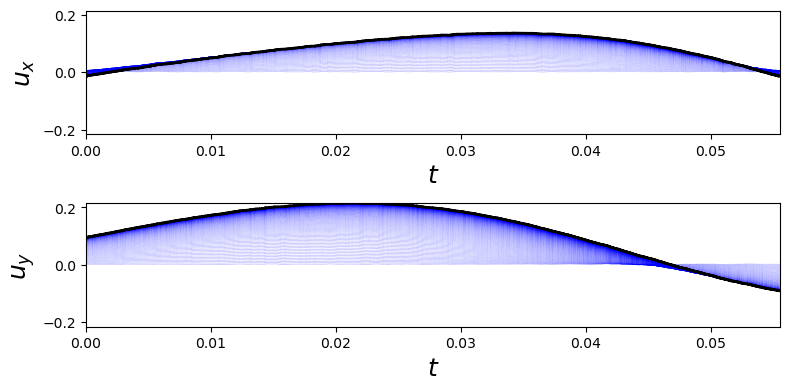

In [54]:
plot_grape_control_fields(times, result.u[:, :, :] / (2 * pi), H_labels, uniform_axes=True);
plt.show()

# Calcuate fidelity

In [59]:
print(startingstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [55]:
idealfinalstate=U*startingstate
print (idealfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.-1.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]


In [56]:
result.U_f.tidyup(1e-2)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 0.        +0.j          0.        +0.j          0.        +0.j
   0.28725478-0.95785421j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j         -0.47879896-0.87792458j  0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.28715928-0.95788285j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.28726571-0.95785093j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.47879895-0.87792458j  0.        +0.j
   0.  

In [57]:
realfinalstate=result.U_f*startingstate
print (realfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.28726571-0.95785093j]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]]


In [58]:
idealdensitymatrix=(idealfinalstate * idealfinalstate.dag())#ideal density matrix
densitymatrix=(realfinalstate * realfinalstate.dag())# real density matrix
print (idealdensitymatrix)
print (densitymatrix)
fidelity(idealdensitymatrix,densitymatrix)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


0.9999999994753501